### Sign Language Classification with SVM

In [1]:
# 1. Imports
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from string import ascii_lowercase
import seaborn as sns
from sklearn.model_selection import GridSearchCV

#### Data Loading

In [2]:
DATASET_PATH = "./data/images_manipulated/"
CSV_FILE = "labels_manipulated.csv"
IMG_SIZE = (128, 128)
CLASS_NAMES = list(map(str, range(10))) + list(ascii_lowercase)
CLASSES = len(CLASS_NAMES)

In [3]:
import csv
# Utility function

def read_csv(csv_file):
    with open(csv_file, newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
    return data

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils, io
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt
import os

from string import ascii_lowercase

class SignLangDataset(Dataset):
    """Sign language dataset"""

    def __init__(self, csv_file, root_dir, transform=transforms.Compose([transforms.Resize((128, 128)),transforms.ToTensor(),])):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = read_csv(os.path.join(root_dir,csv_file))
        self.root_dir = root_dir
        self.transform = transform
        # List of class names in order
        self.class_names = CLASS_NAMES

    def __len__(self):
        """
        Calculates the length of the dataset-
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns one sample (dict consisting of an image and its label)
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Read the image and labels
        image_path = os.path.join(self.root_dir, self.data[idx][1])
        
        # Read image as a grayscale PIL image
        image = Image.open(image_path).convert("L")  # 'L' = grayscale mode

        if self.transform:
            image = self.transform(image)

        # The label is the index of the class name in the list ['0','1',...,'9','a','b',...'z']
        # because we should have integer labels in the range 0-35 (for 36 classes)
        label = self.class_names.index(self.data[idx][0])
        
        sample = {'image': image, 'label': label}

        return sample
    
    def show_sample(self, idx: int) -> None:
        """
        Displays a grayscale image with its corresponding class label (0-35).
        
        Args:
            image (numpy.ndarray): The image to display. Shape should be (1, H, W) or (H, W).
            label (int): Integer label in range 0-35.
        """

        sample = self[idx]
        image = sample["image"]
        label_index = sample["label"]
        label = self.class_names[label_index]

        # Flatten channel dimension if needed
        if image.ndim == 3 and image.shape[0] == 1:
            image = image[0] 
        
        plt.imshow(image, cmap="gray")
        plt.title(f"Label: {label}")
        plt.axis("off")
        plt.show()

# Define label mapping
class_names = list(map(str, range(10))) + list(ascii_lowercase)

# Transform Images to 128x128
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),             # Resize to 128x128
    transforms.ToTensor(),                   # Converts HxW numpy → CxHxW tensor
])

In [5]:
class DuplicatedAugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, augment_fn, duplicate_factor=2):
        """
        Args:
            base_dataset: Original dataset (e.g. SignLangDataset)
            augment_fn: A torchvision transform to apply to duplicates
            duplicate_factor: How many times to duplicate each original sample
        """
        self.base_dataset = base_dataset
        self.augment_fn = augment_fn
        self.duplicate_factor = duplicate_factor

    def __len__(self):
        return len(self.base_dataset) * self.duplicate_factor

    def __getitem__(self, idx):
        base_idx = idx % len(self.base_dataset)
        original_sample = self.base_dataset[base_idx]

        if idx // len(self.base_dataset) > 0:
            # Convert tensor back to PIL and apply augmentation
            image = transforms.ToPILImage()(original_sample['image'])
            image = self.augment_fn(image)
        else:
            image = original_sample['image']

        return {'image': image, 'label': original_sample['label']}

In [6]:
def dataset_to_numpy(dataset):
    """
    Converts a PyTorch Dataset into NumPy arrays for use with sklearn.
    Assumes images are transformed to shape [1, 128, 128].

    Returns:
        X: np.ndarray of shape [num_samples, 128*128]
        y: np.ndarray of shape [num_samples]
    """
    X = []
    y = []
    for i in range(len(dataset)):
        sample = dataset[i]
        image = sample['image'].numpy().squeeze()  # [1, 128, 128] -> [128, 128]
        X.append(image.flatten())
        y.append(sample['label'])

    return np.array(X), np.array(y)

In [7]:
# Load and split data
sign_dataset = SignLangDataset(CSV_FILE, DATASET_PATH, transform)

# Define split sizes
val_size = int(0.2 * len(sign_dataset))
train_size = len(sign_dataset) - val_size

# Split the dataset
generator = torch.Generator().manual_seed(47) # for reproducability
train_dataset, val_dataset = random_split(sign_dataset, [train_size, val_size])#, generator=generator)

augmentation = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),  # 👈 force RGB
    transforms.Resize((128, 128)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.Grayscale(num_output_channels=1),        # 👈 back to grayscale tensor
    transforms.ToTensor(),  # 👈 back to tensor
])

# Create augmented dataset (2× bigger)
augmented_train_dataset = DuplicatedAugmentedDataset(
    base_dataset=train_dataset,
    augment_fn=augmentation,
    duplicate_factor=1
)

X_train, y_train = dataset_to_numpy(augmented_train_dataset)
X_val, y_val = dataset_to_numpy(val_dataset)

print("Train samples:", len(X_train))
print("Validation samples:", len(X_val))

Train samples: 14445
Validation samples: 3611


#### Feature Extraction

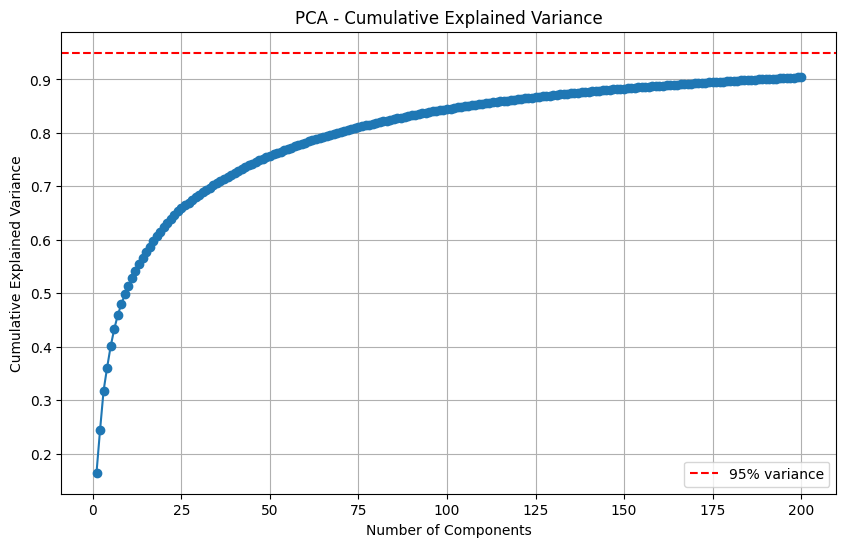

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=200)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Get explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.legend()
plt.show()

In [9]:
import joblib
# Save PCA model to file
joblib.dump(pca, 'pca_200components_90v.pkl')

['pca_200components_90v.pkl']

#### Training

Train Accuracy: 100.00%
Validation Accuracy: 89.20%
{'0': {'precision': 0.868421052631579, 'recall': 0.9339622641509434, 'f1-score': 0.9, 'support': 106.0}, '1': {'precision': 0.8641975308641975, 'recall': 0.813953488372093, 'f1-score': 0.8383233532934131, 'support': 86.0}, '2': {'precision': 0.6506024096385542, 'recall': 0.6352941176470588, 'f1-score': 0.6428571428571429, 'support': 85.0}, '3': {'precision': 0.9438202247191011, 'recall': 0.9130434782608695, 'f1-score': 0.9281767955801105, 'support': 92.0}, '4': {'precision': 0.9217391304347826, 'recall': 0.905982905982906, 'f1-score': 0.9137931034482759, 'support': 117.0}, '5': {'precision': 0.9438202247191011, 'recall': 0.9230769230769231, 'f1-score': 0.9333333333333333, 'support': 91.0}, '6': {'precision': 0.8148148148148148, 'recall': 0.8888888888888888, 'f1-score': 0.8502415458937198, 'support': 99.0}, '7': {'precision': 0.8837209302325582, 'recall': 0.7835051546391752, 'f1-score': 0.8306010928961749, 'support': 97.0}, '8': {'prec

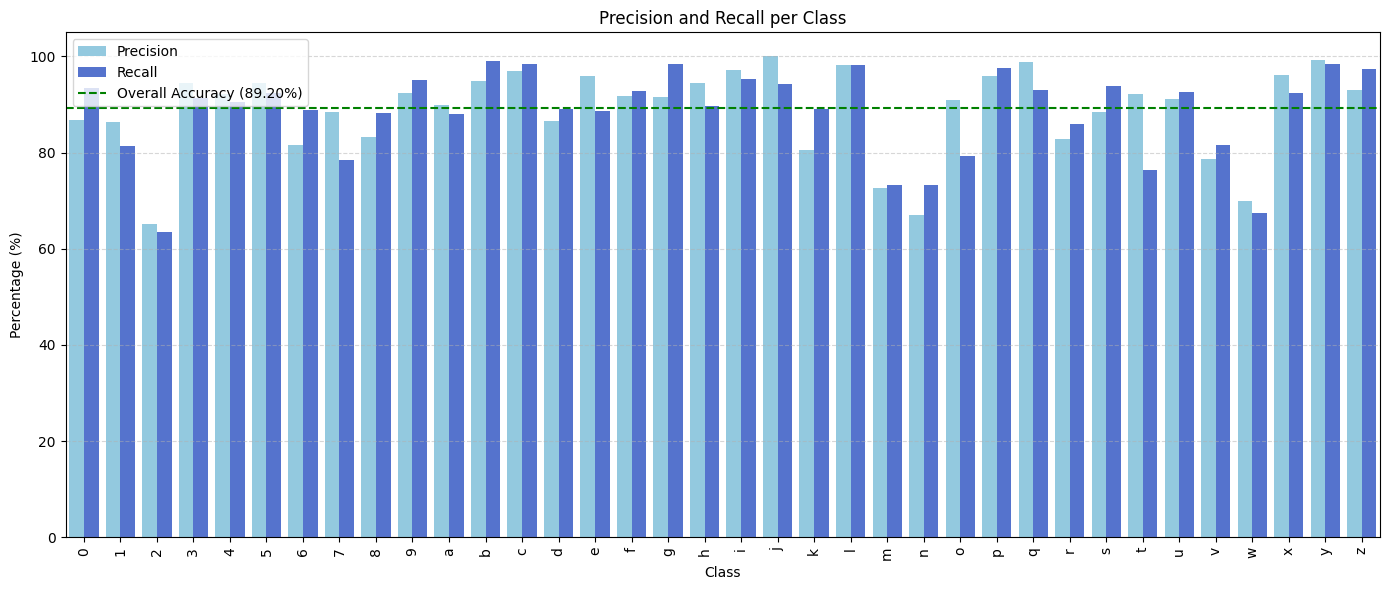

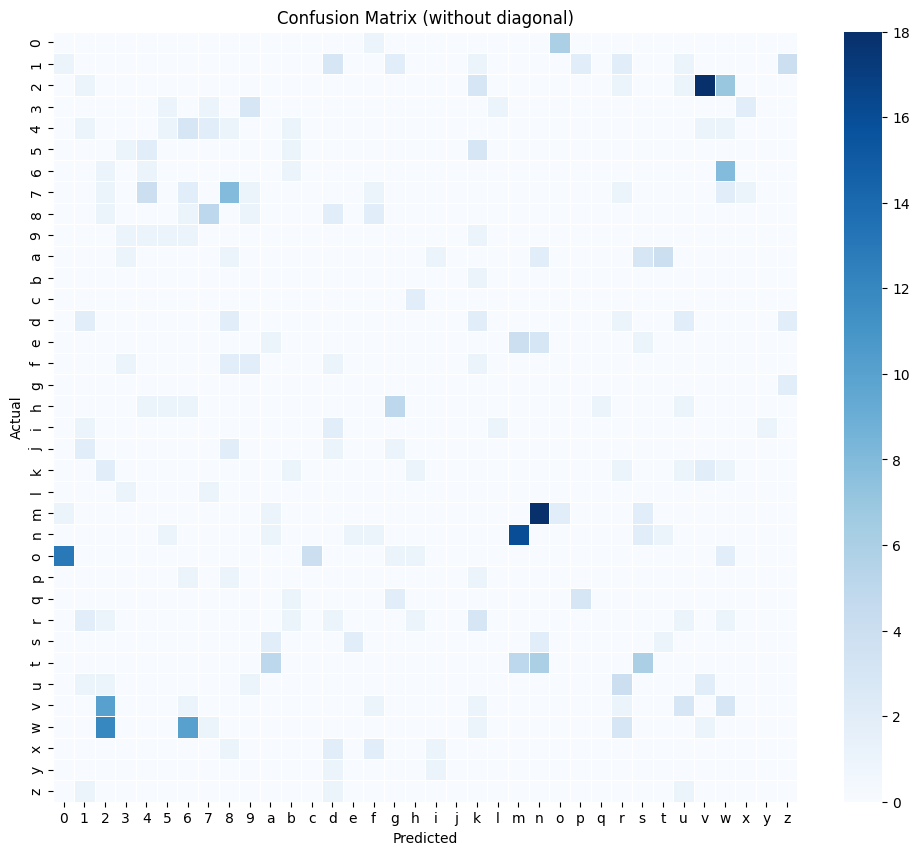

In [ ]:
import pandas as pd

# 4. Train SVM
svm = SVC(C=6, kernel="poly", gamma=0.01, degree=3, coef0=1, decision_function_shape="ovr")
svm.fit(X=X_train_pca, y=y_train)

# 5. Evaluate
y_pred_train = svm.predict(X_train_pca)
acc_train = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {acc_train:.2%}")

y_pred = svm.predict(X_val_pca)
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.2%}")
report = classification_report(y_val, y_pred, target_names=CLASS_NAMES, output_dict=True)
print(report)

# Generate classification report
report_dict = classification_report(y_val, y_pred, target_names=CLASS_NAMES, output_dict=True)
overall_accuracy = accuracy_score(y_val, y_pred)

# Build DataFrame for precision and recall
data = {
    'Class': CLASS_NAMES,
    'Precision': [report_dict[label]['precision'] * 100 for label in CLASS_NAMES],
    'Recall': [report_dict[label]['recall'] * 100 for label in CLASS_NAMES]
}

df = pd.DataFrame(data)
df_melted = df.melt(id_vars='Class', var_name='Metric', value_name='Score')

# Plot using seaborn
plt.figure(figsize=(14, 6))
sns.barplot(data=df_melted, x='Class', y='Score', hue='Metric', palette=['skyblue', 'royalblue'])

# Add overall accuracy line
plt.axhline(overall_accuracy * 100, color='green', linestyle='--', label=f'Overall Accuracy ({overall_accuracy:.2%})')

# Customize
plt.title('Precision and Recall per Class')
plt.ylabel('Percentage (%)')
plt.ylim(0, 105)
plt.xticks(rotation=90)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 6. Confusion Matrix (optional)
cm = confusion_matrix(y_val, y_pred)
np.fill_diagonal(cm, 0)  # Zero out diagonal to highlight errors

plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            annot=False, cmap="Blues", linewidths=0.5)
plt.title("Confusion Matrix (without diagonal)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

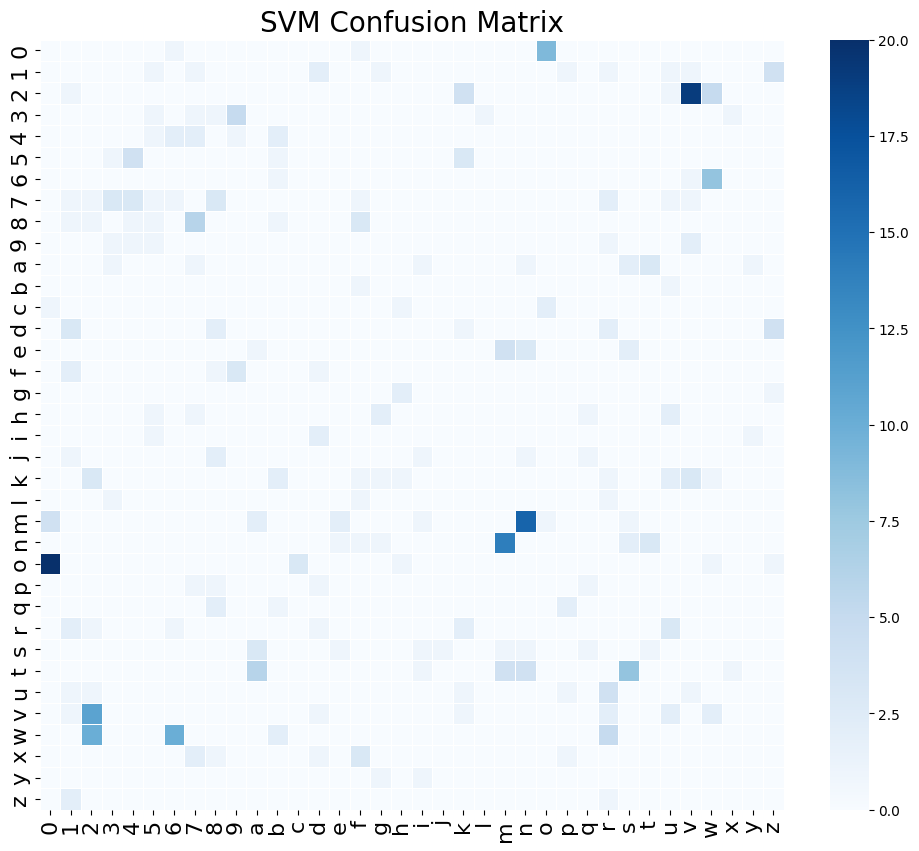

: 

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names, caption="Confusion Matrix (without diagonal)"):
    """
    Plots a confusion matrix using matplotlib.
    
    Args:
        y_true (list or array): Ground truth labels.
        y_pred (list or array): Predicted labels.
    """
    cm = confusion_matrix(y_true, y_pred)
    np.fill_diagonal(cm, 0)  # Zero out diagonal to highlight errors

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names,
                annot=False, cmap="Blues", linewidths=0.5)
    
    plt.title(caption, fontsize=20)
    plt.xlabel("", fontsize=16)
    plt.ylabel("", fontsize=16)
    plt.xticks(fontsize=16, rotation=90)
    plt.yticks(fontsize=16)

CLASS_NAMES = list(map(str, range(10))) + list(ascii_lowercase)
plot_confusion_matrix(y_val, y_pred, CLASS_NAMES, "SVM Confusion Matrix")


In [12]:
import joblib
joblib.dump(svm, "svm_89a_poly_d3_c6_g01.pkl")

['svm_89a_poly_d3_c6_g01.pkl']

#### Combined Pipeline

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import joblib

# Build pipeline
pipeline = Pipeline([
    ('pca', PCA(n_components=200)),
    ('svm', SVC(C=6, kernel="poly", gamma=0.01, degree=3, coef0=1, decision_function_shape="ovr"))
])

# Train
pipeline.fit(X_train, y_train)

# Save
joblib.dump(pipeline, 'pca_svm_pipeline.pkl')

# Later or elsewhere...
pipeline = joblib.load('pca_svm_pipeline.pkl')
y_pred = pipeline.predict(X_val)

acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.2%}")
report = classification_report(y_val, y_pred, target_names=CLASS_NAMES, output_dict=True)
print(report)

Validation Accuracy: 87.62%
{'0': {'precision': 0.8, 'recall': 0.9345794392523364, 'f1-score': 0.8620689655172415, 'support': 107.0}, '1': {'precision': 0.8762886597938144, 'recall': 0.85, 'f1-score': 0.8629441624365483, 'support': 100.0}, '2': {'precision': 0.6125, 'recall': 0.550561797752809, 'f1-score': 0.5798816568047338, 'support': 89.0}, '3': {'precision': 0.8936170212765957, 'recall': 0.9438202247191011, 'f1-score': 0.9180327868852459, 'support': 89.0}, '4': {'precision': 0.8615384615384616, 'recall': 0.9411764705882353, 'f1-score': 0.8995983935742972, 'support': 119.0}, '5': {'precision': 0.872093023255814, 'recall': 0.9036144578313253, 'f1-score': 0.8875739644970415, 'support': 83.0}, '6': {'precision': 0.7416666666666667, 'recall': 0.8090909090909091, 'f1-score': 0.7739130434782608, 'support': 110.0}, '7': {'precision': 0.8857142857142857, 'recall': 0.7848101265822784, 'f1-score': 0.8322147651006712, 'support': 79.0}, '8': {'precision': 0.9080459770114943, 'recall': 0.8061224

#### Grid Search

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'kernel': 'poly', 'gamma': 0.021544346900318822, 'degree': 3, 'decision_function_shape': 'ovo', 'coef0': 1, 'C': 0.03593813663804628}
Best accuracy: 0.771374177916234
Validation Accuracy: 88.48%
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       106
           1       0.84      0.81      0.83        86
           2       0.73      0.68      0.71        85
           3       0.92      0.90      0.91        92
           4       0.92      0.94      0.93       117
           5       0.97      0.92      0.94        91
           6       0.79      0.82      0.81        99
           7       0.91      0.75      0.82        97
           8       0.86      0.88      0.87       102
           9       0.90      0.95      0.92       102
           a       0.90      0.84      0.87       100
           b       0.93      0.99      0.96       114
           c       0.96    

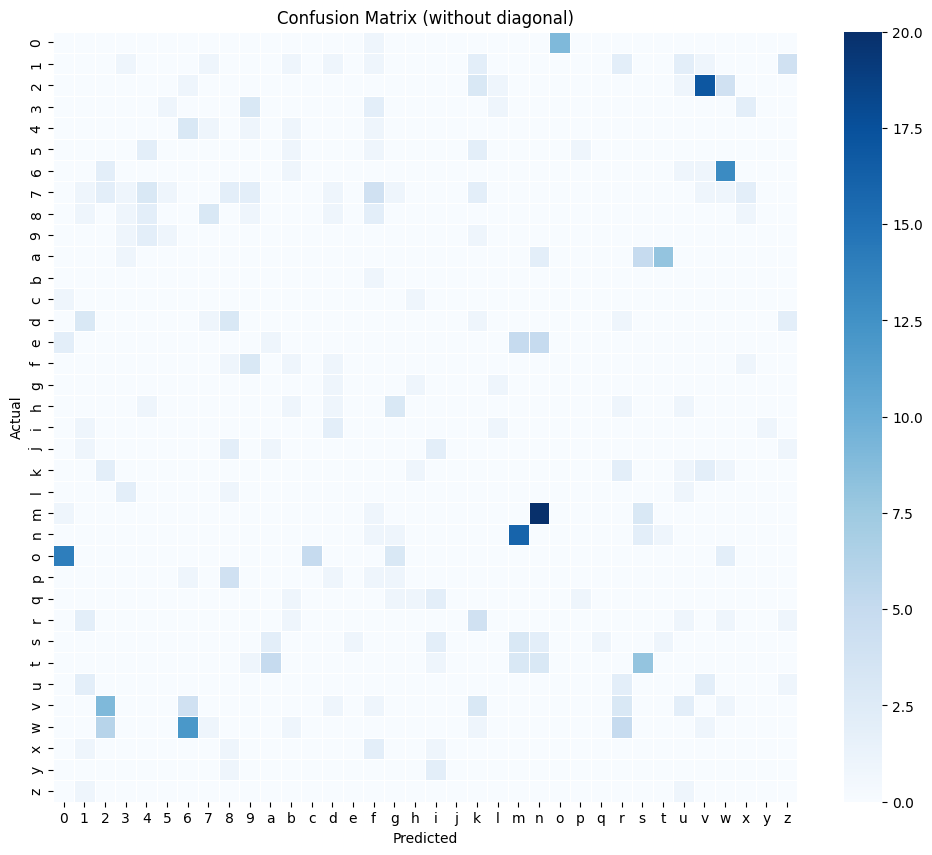

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# 4. Train SVM
param_grid = {
    'C': np.logspace(-2, 3, 10),
    'gamma': np.logspace(-4, -1, 10),
    'kernel': ['rbf'],
}

param_grid = [
    {
        'C': np.logspace(-2, 3, 10),
        'gamma': np.logspace(-4, -1, 10),
        'kernel': ['rbf'],
        'decision_function_shape': ["ovo"]
    },
    {
        'kernel': ['linear'],
        'C': np.logspace(-2, 3, 10),
        'decision_function_shape': ["ovo"]
    },
    {
        'kernel': ['poly'],
        'C': np.logspace(-2, 3, 10),
        'gamma': np.logspace(-4, -1, 10),
        'degree': [2, 3, 4],  # common degrees
        'coef0': [0, 1],       # optional, especially useful for poly
        'decision_function_shape': ["ovo"]
    },
]

grid_search = RandomizedSearchCV(SVC(), param_grid, n_iter=20, scoring='accuracy', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

print("Best params:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

svm = grid_search.best_estimator_

# 5. Evaluate
y_pred = svm.predict(X_val_pca)
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.2%}")
print(classification_report(y_val, y_pred, target_names=CLASS_NAMES))

# 6. Confusion Matrix (optional)
cm = confusion_matrix(y_val, y_pred)
np.fill_diagonal(cm, 0)  # Zero out diagonal to highlight errors

plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            annot=False, cmap="Blues", linewidths=0.5)
plt.title("Confusion Matrix (without diagonal)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
import joblib

joblib.dump(svm, "svm_random_search.pkl")
# joblib.load("svm_random_search.pkl")

['svm_random_search.pkl']

### Grid Search Results

In [ ]:
import pandas as pd

# Convert results to a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Show key columns
results_df = results_df.sort_values(by='rank_test_score')
results_df = results_df[['rank_test_score', 'mean_test_score', 'params']]

# Display nicely
from IPython.display import display
display(results_df)
results_df.to_csv("grid_search_svm_results.csv", index=False)

,rank_test_score,mean_test_score,params
11,1,0.771374,"{'kernel': 'poly', 'gamma': 0.0215443469003188..."
13,2,0.757113,"{'kernel': 'poly', 'gamma': 0.1, 'degree': 3, ..."
15,3,0.730183,"{'kernel': 'poly', 'gamma': 0.01, 'degree': 2,..."
18,4,0.729007,"{'kernel': 'poly', 'gamma': 0.0215443469003188..."
19,5,0.438352,"{'kernel': 'linear', 'decision_function_shape'..."
14,6,0.409623,"{'kernel': 'rbf', 'gamma': 0.00046415888336127..."
17,7,0.406404,"{'kernel': 'linear', 'decision_function_shape'..."
16,8,0.406196,"{'kernel': 'rbf', 'gamma': 0.02154434690031882..."
4,9,0.361613,"{'kernel': 'poly', 'gamma': 0.0046415888336127..."
3,10,0.323884,"{'kernel': 'poly', 'gamma': 0.0021544346900318..."


In [ ]:
import pandas as pd

# Load both result files
df_poly = pd.read_csv("./grid_search_svm_results.csv")
df_rbf = pd.read_csv("./docs/svm/svm_random_search.csv")

# Combine both into one DataFrame
combined = pd.concat([df_poly, df_rbf], ignore_index=True)

# Sort by mean_test_score descending
combined = combined.sort_values(by="mean_test_score", ascending=False)

# Re-rank
combined["rank_test_score"] = range(1, len(combined) + 1)

# Reorder columns
combined = combined[["rank_test_score", "mean_test_score", "params"]]

# Save to CSV
combined.to_csv("combined_ranked_results.csv", index=False)

## Prediction Stub

You will need to provide a function that can be used to make predictions using your final trained model. 

**IMPORTANT**

1. The name of your prediction function must be `leader_board_predict_fn`
2. Your prediction function should be able take as input a 4-D numpy array of shape [batch_size,1,128,128] and produce predictions in the form of a 1-D numpy array of shape [batch_size,]. 
3. Predictions for each image should be an integer in the range 0-35, that is `0` for the digit $0$, `1` for the digit $1$, .... , `9` for the digit $9$, `10` for the letter $a$, `11` for the letter $b$, ..., `35` for the letter $z$.
4. Your prediction function should internally load your trained model and take care of any data transformations that you need.

Below we provide an implementation of the `leader_board_predict_fn` function, in which we show how a trained model can be loaded (from the weights saved on the disk) for making predictions. This example is for PyTorch, but you are free to use any framework of your choice for your model. The only requirement is that this function should accept a numpy array (with the proper shape) as the input and should produce a numpy array (with the proper shape) as the output. What you do internally is up to you.

Note that the model that we load here is not properly trained and so its performance is very bad. This example is only for showing you how a model can be loaded in PyTorch and how predictions can be made.

In [10]:
def leader_board_predict_fn(input_batch):
    """
    Function for making predictions using your trained model.
    
    Args:
        input_batch (numpy array): Input images (4D array of shape 
                                   [batch_size, 1, 128, 128])
        
    Returns:
        output (numpy array): Predictions of the your trained model 
                             (1D array of int (0-35) of shape [batch_size, ])
    """
    prediction = None
    
    batch_size, channels, height, width = input_batch.shape

    # Flatten input: [batch_size, 1, 128, 128] -> [batch_size, 128*128]
    input_batch_flat = input_batch.reshape(batch_size, -1)

    import joblib

    pipeline = joblib.load('pca_svm_pipeline.pkl')
    prediction = pipeline.predict(input_batch_flat)

    assert prediction is not None, "Prediction cannot be None"
    assert isinstance(prediction, np.ndarray), "Prediction must be a numpy array"

    return prediction

## Evaluation

Your final model will be evaluated on a hidden test set containing images similar to the dataset that you are provided with.

For evaluating the performance of your model, we will use the normalized [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) metric from sklearn. This is simply the percentage of correct predictions that your model makes for all the images of the hidden test set. Hence, if all the predictions are correct, the score is 1.0 and if all predictions are incorrect, the score is 0.0. We will use the sklearn metric so that the accuracy function is agnostic to the machine learning framework you use.

In [11]:
from sklearn.metrics import accuracy_score
  
def accuracy(dataset_path, max_batches=30):
    """
    Calculates the average prediction accuracy.
    
    IMPORTANT
    =========
    In this function, we use PyTorch only for loading the data. When your `leader_board_predict_fn`
    function is called, we pass the arguments to it as numpy arrays. The output of `leader_board_predict_fn`
    is also expected to be a numpy array. So, as long as your `leader_board_predict_fn` function takes
    numpy arrays as input and produces numpy arrays as output (with the proper shapes), it does not
    matter what framework you used for training your network or for producing your predictions.
    
    Args:
        dataset_path (str): Path of the dataset directory
        
    Returns:
        accuracy (float): Average accuracy score over all images (float in the range 0.0-1.0)
    """

    # Create a Dataset object
    sign_lang_dataset = SignLangDataset(csv_file="labels.csv", root_dir=dataset_path)

    # Create a Dataloader
    sign_lang_dataloader = DataLoader(sign_lang_dataset, 
                                      batch_size=64,
                                      shuffle=True, 
                                      drop_last=True,
                                      num_workers=0)
    
    # Calculate accuracy for each batch
    accuracies = list()
    for batch_idx, sample in enumerate(sign_lang_dataloader):
        x = sample["image"].numpy()
        y = sample["label"].numpy()
        prediction = leader_board_predict_fn(x)
        accuracies.append(accuracy_score(y, prediction, normalize=True))
        
        # We will consider only the first 30 batches
        if batch_idx == (max_batches - 1):
            break

    assert len(accuracies) == max_batches
    
    # Return the average accuracy
    mean_accuracy = np.mean(accuracies)
    return mean_accuracy

We will now use your `leader_board_predict_fn` function for calculating the accuracy of your model. We provide the code for testing your loaded model on the visible training data. We will also evaluate your model's performance on the test dataset (the test dataset should only be used for evaluation and is **NOT** to be used for training your model).

In [12]:
DATASET_PATH="./data/images"

def get_score():
    """
    Function to compute scores for train and test datasets.
    """
    import torch
    import numpy as np
    from sklearn.metrics import accuracy_score
    import os
    import pwd
    import time
    import pathlib
    import pandas as pd
    import datetime
    
    ### LEADER BOARD TEST
    seed = 200

    torch.manual_seed(seed)
    np.random.seed(seed)

    # Calculate the accuracy on the training dataset
    # to check that your `leader_board_predict_fn` function 
    # works without any error
    dataset_score = accuracy(dataset_path=DATASET_PATH)

    assert isinstance(dataset_score, float), f"type of dataset_score is {type(dataset_score)}, but it must be float"
    assert 0.0<=dataset_score<=1.0, f"Value of dataset_score is {dataset_score}, but it must be between 0.0 and 1.0"

    # This is your accuracy score on the visible training dataset
    # This is NOT used for the leaderboard.
    print(f"Accuracy score on training data: {dataset_score}")

    # There is a hidden test that will evaluate your trained model on the hidden test set
    # This hidden dataset and the accuracy for this will not be visible to you when you
    # validate this notebook. The accuracy score on the hidden dataset will be used
    # for calculating your leaderboard score.

    seed = 200

    torch.manual_seed(seed)
    np.random.seed(seed)

    user_id = pwd.getpwuid( os.getuid() ).pw_name
    curtime = time.time()
    dt_now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

    try:  # 
        HIDDEN_DATASET_PATH = os.path.expanduser("/data/mlproject22-test-data/sign_lang_test")
        hiddendataset_score = accuracy(dataset_path=HIDDEN_DATASET_PATH)

        assert isinstance(hiddendataset_score, float), f"type of dataset_score is {type(dataset_score)}, but it must be float"
        assert 0.0<=hiddendataset_score<=1.0, f"Value of dataset_score is {dataset_score}, but it must be between 0.0 and 1.0"

        print(f"Leaderboard score: {hiddendataset_score}")

        score_dict = dict(
            score_hidden=hiddendataset_score,
            score_train=dataset_score,
            unixtime=curtime,
            user=user_id,
            dt=dt_now,
            comment="",
        )

    except Exception as e:
        err = str(e)
        score_dict = dict(
            score_hidden=float("nan"),
            score_train=dataset_score,
            unixtime=curtime,
            user=user_id,
            dt=dt_now,
            comment=err
        )


    #if list(pathlib.Path(os.getcwd()).parents)[0].name == 'source':
    #    print("we are in the source directory... replacing values.")
    #    print(pd.DataFrame([score_dict]))
    #    score_dict["score_hidden"] = -1
    #    score_dict["score_train"] = -1
    #    print("new values:")
    #    print(pd.DataFrame([score_dict]))

    pd.DataFrame([score_dict]).to_csv("sign_lang.csv", index=False)

    ### LEADER BOARD TEST
    
get_score()

Accuracy score on training data: 0.9760416666666667
